# Topic Modeling Experiments

Several experiments in topic modeling. 

In [122]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
import pandas as pd
from pandas.io.json import json_normalize
import json
import math
from matplotlib import pyplot

Setup and seed both numpy and nltk.

In [29]:
np.random.seed(1337)
nltk.download('wordnet')
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carlcortright/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Utils

A bunch of utils for cleaning and pre-processing data

In [224]:
def bucket_times(data, seconds=30):
    buckets = {}
    for timeframe in data:
        bucket = math.floor(timeframe['start']/seconds)
        buckets[bucket] = buckets.get(bucket, "") + timeframe['text'] + " "
    formatted = []
    for k, v in buckets.items():
        formatted.append({'bucket': k, 'text': v})
    return formatted

def json_file_to_pd(filepath):
    f = open(filepath, 'r')
    data = json.load(f)
    data = bucket_times(data)
    df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
    return df

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


In [225]:
raw = json_file_to_pd('test.json')
raw.head()

,bucket,text
0,0,this next problem is a bit of a classic and I'...
1,1,they say 24 inches square so it is 24 by 24 sq...
2,2,equal size square there and then it cut an equ...
3,3,should I cut out in order to maximize the volu...
4,4,the base and what are the dimensions of the ba...


In [226]:
doc_sample = raw.loc[[1]].values[0][1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['they', 'say', '24', 'inches', 'square', 'so', 'it', 'is', '24', 'by', '24', 'square', 'by', 'cutting', 'equal', 'squares', 'from', 'the', 'corners', 'and', 'turning', 'up', 'the', 'sides', 'so', 'what', 'are', 'they', 'saying', 'well', "they're", 'say', "we're", 'going', 'to', 'cut', 'equal', 'squares', 'from', 'the', 'corner', 'so', "let's", 'say', 'we', 'cut', 'a', 'and', 'let', 'me', 'see', 'if', 'I', 'can', 'draw', 'this', 'well', 'so', "I'm", 'going', 'to', 'cut', 'a', 'square', 'here', 'and', "I'm", 'going', 'to', 'cut', 'an', 'equal', 'size', 'square', 'there', 'I', 'want', 'to', 'draw', 'this', 'neatly', 'and', 'then', 'I', 'cut', 'it', '']


 tokenized and lemmatized document: 
['inch', 'squar', 'squar', 'cut', 'equal', 'squar', 'corner', 'turn', 'side', 'say', 'go', 'equal', 'squar', 'corner', 'draw', 'go', 'squar', 'go', 'equal', 'size', 'squar', 'want', 'draw', 'neat']


In [227]:
processed_docs = raw['text'].map(preprocess)

In [228]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# count = 0
# for k, v in dictionary.iteritems():
#     print(k, v)
#     count += 1
#     if count > 10:
#         break

In [229]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_doc_4310 = bow_corpus[1]
# for i in range(len(bow_doc_4310)):
#     print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], dictionary[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

In [230]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [231]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)
# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

ValueError: cannot compute LDA over an empty collection (no terms)

In [232]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)
# for idx, topic in lda_model_tfidf.print_topics(-1):
#     print('Topic: {} Word: {}'.format(idx, topic))

ValueError: cannot compute LDA over an empty collection (no terms)

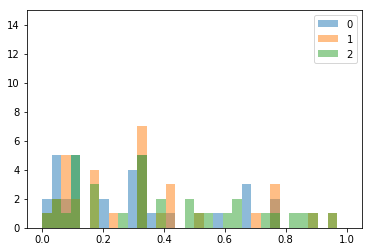

In [212]:
histograms = {}
for i in range(0, len(bow_corpus)):
    for index, score in sorted(lda_model[bow_corpus[i]], key=lambda tup: -1*tup[1]):
        histograms[index] = histograms.get(index, list()) + [score]

        
bins = np.linspace(0, 1, len(bow_corpus))
for topic, scores in histograms.items():
    pyplot.hist(scores, bins, alpha=0.5, label=str(topic))
pyplot.legend(loc='upper right')
axes = pyplot.gca()
axes.set_ylim([0,15])
pyplot.show()